# **Predicting car accident injuries in Maryland**
Dalia Cabrera, Ahmed Torki, Sergio Zavala

*May 1, 2025*

## Introduction

Using crash-related factors like weather, vehicle damage, and and surface condition, can we predict the likelihood of driver injury? In this project, we explore that question by building two machine learning models using data from the Maryland Open Crash Reporting System.

Our primary goal is to classify injury severity based on pre-crash and crash-related conditions. Along the way, we also aim to explore broader questions:

- What circumstances are most strongly associated with injury during a crash?

- Can such models help inform safer driving habits under risky conditions?

- In early moments after a crash (before official reports), could predictive tools help families understand the likelihood of injury?

## Read the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
url = 'https://drive.google.com/file/d/1_ej7isccNUR2JAtaHQrRgqGFucWWP_gK/view?usp=share_link'
file_id = url.split('/')[-2]
read_url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(read_url)

<ipython-input-2-f29cc2ba96f2>:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(read_url)


## Initial exploration

To get a feel for the data, we ran `.head()`, `.shape`, `.columns`, `.info()`, and `.describe()`.



#### `.head()` gives us a quick peek at the first few rows.  

In [3]:
df.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location
0,DM8479000T,210020119,Takoma Park Police Depart,Property Damage Crash,05/27/2021 07:40:00 PM,NaN,NaN,NaN,IN PARKING LOT,NaN,...,NaN,0,No,Yes,2017,HINO,TWK,38.987657,-76.987545,"(38.98765667, -76.987545)"
1,MCP2970000R,15045937,MONTGOMERY,Property Damage Crash,09/11/2015 01:29:00 PM,NaN,NaN,NaN,Parking Lot: \n2525 Ennalls Ave,NaN,...,South,5,No,No,2012,TOYOTA,SU,39.039917,-77.053649,"(39.03991652, -77.05364898)"
2,MCP20160036,180040948,Montgomery County Police,Property Damage Crash,08/17/2018 02:25:00 PM,NaN,NaN,NaN,PARKING LOT OF 16246 FREDERICK RD,NaN,...,West,15,No,No,2015,MAZD,TK,38.743373,-77.546997,"(38.743373, -77.54699707)"
3,EJ7879003C,230048975,Gaithersburg Police Depar,Injury Crash,08/11/2023 06:00:00 PM,NaN,NaN,NaN,1 N SUMMIT DRIVE,NaN,...,Unknown,15,No,No,2018,RAM,TK,39.145873,-77.191940,"(39.14587303, -77.19194047)"
4,MCP2967004Y,230070277,Montgomery County Police,Property Damage Crash,12/06/2023 06:42:00 PM,Maryland (State),CONNECTICUT AVE,BALTIMORE ST,NaN,KENSINGTON,...,South,35,No,No,2017,AUDI,A3,39.025170,-77.076333,"(39.02517017, -77.07633333)"


#### `.shape` tells us how big the dataset is.  


In [4]:
df.shape

(195692, 39)

#### `.columns` lets us scroll through all the column names to see what we're working with.  




In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195692 entries, 0 to 195691
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Report Number                  195692 non-null  object 
 1   Local Case Number              195692 non-null  object 
 2   Agency Name                    195692 non-null  object 
 3   ACRS Report Type               195692 non-null  object 
 4   Crash Date/Time                195692 non-null  object 
 5   Route Type                     176568 non-null  object 
 6   Road Name                      174569 non-null  object 
 7   Cross-Street Name              164921 non-null  object 
 8   Off-Road Description           18086 non-null   object 
 9   Municipality                   19126 non-null   object 
 10  Related Non-Motorist           6310 non-null    object 
 11  Collision Type                 195107 non-null  object 
 12  Weather                       

#### `.info()` showed us the data types and how much missing data there might be.  


In [6]:
df.describe()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,195692.000000,195692.000000,195692.000000,195692.000000
mean,32.298229,1965.631855,39.083074,-77.112138
std,11.237255,340.581440,0.071862,0.098248
min,0.000000,0.000000,37.720000,-79.486000
25%,25.000000,2006.000000,39.024425,-77.189364
50%,35.000000,2012.000000,39.074865,-77.105216
75%,40.000000,2016.000000,39.139840,-77.039155
max,75.000000,9999.000000,39.990414,-75.527708


#### `.describe()` gave us some basic stats for the numeric columns.

In [7]:
df.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault',
       'Injury Severity', 'Circumstance', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

## Exploration and visualization

### Missing Data Check
We looked at how much data is missing in each column. Some features like Non-Motorist Substance Abuse, Municipality, and Circumstance are missing in over 80% of the rows, so we'll probably drop those or handle them carefully if we decide to keep them. The good news is that most of our key predictors and the target variable (Injury Severity) are mostly complete.



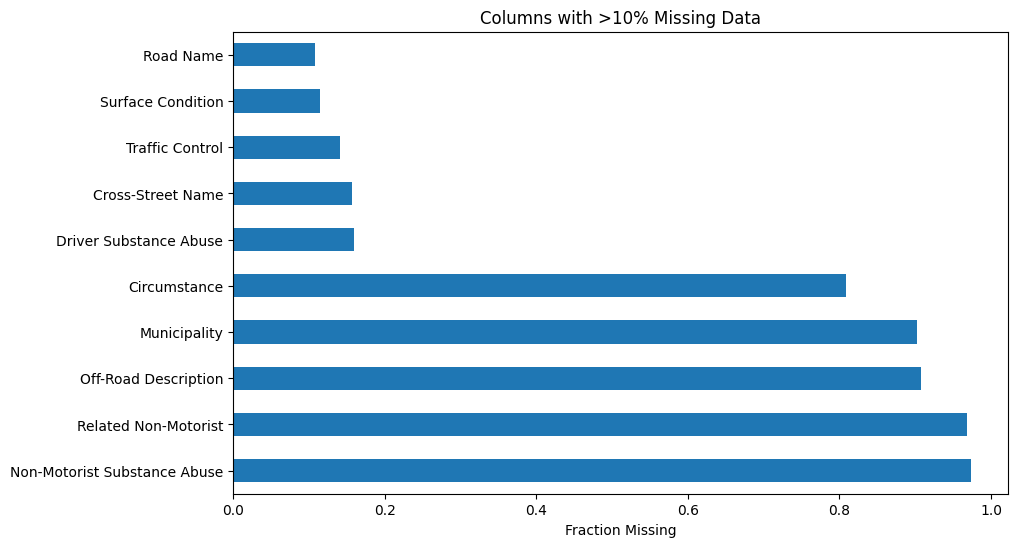

In [8]:
missing_values = df.isna().mean().sort_values(ascending=False)
missing_values[missing_values > 0.1].plot(kind='barh', figsize=(10,6), title='Columns with >10% Missing Data')
plt.xlabel('Fraction Missing')
plt.show();

### Injury Severity Distribution
We looked at how often each injury severity level appears. This showed us that the dataset is highly imbalanced when it comes to the variable target severity.

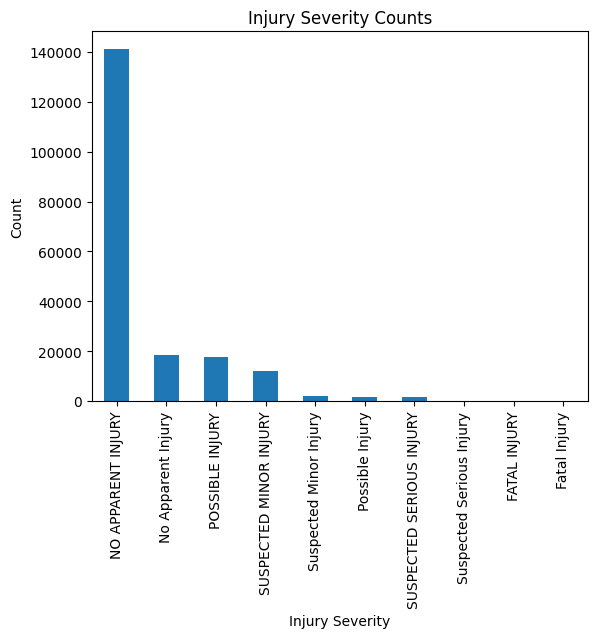

In [9]:
df['Injury Severity'].value_counts().plot(kind='bar', title='Injury Severity Counts')
plt.xlabel('Injury Severity')
plt.ylabel('Count')
plt.show();

### Visualizing Predictor Variables
We explored our predictor variables to see how their values are distributed. Helping us get a better sense of the data and spot anything weird or imbalanced.

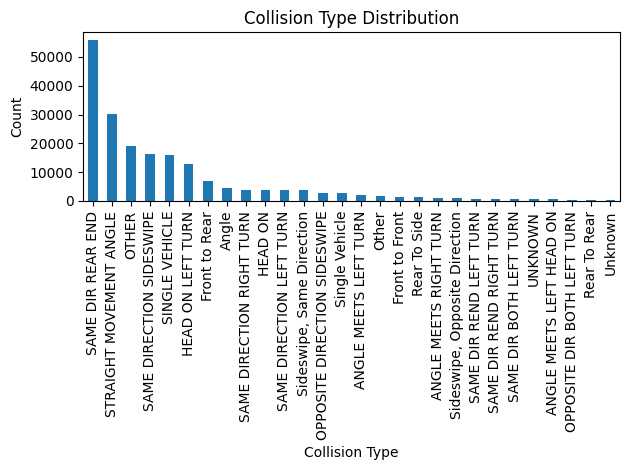

In [10]:
df['Collision Type'].value_counts().plot(kind='bar', title='Collision Type Distribution')
plt.xlabel('Collision Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

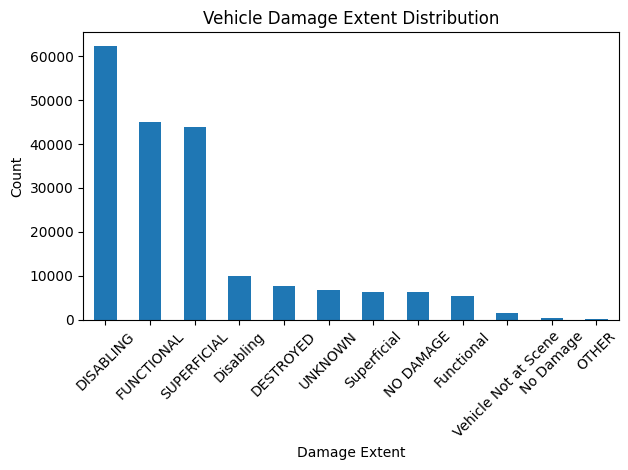

In [11]:
df['Vehicle Damage Extent'].value_counts().plot(kind='bar', title='Vehicle Damage Extent Distribution')
plt.xlabel('Damage Extent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

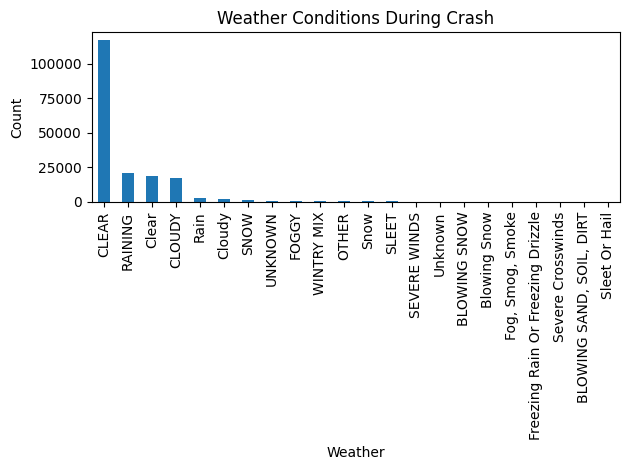

In [12]:
df['Weather'].value_counts().plot(kind='bar', title='Weather Conditions During Crash')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

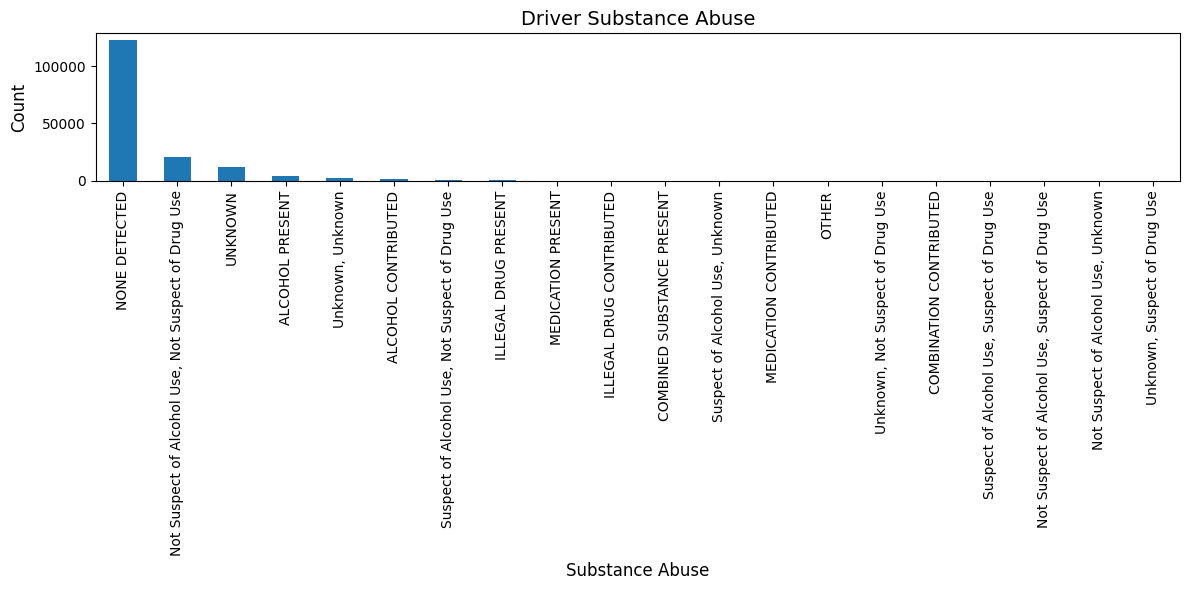

In [13]:
plt.figure(figsize=(12,6))
df['Driver Substance Abuse'].value_counts().plot(kind='bar')
plt.title('Driver Substance Abuse', fontsize=14)
plt.xlabel('Substance Abuse', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

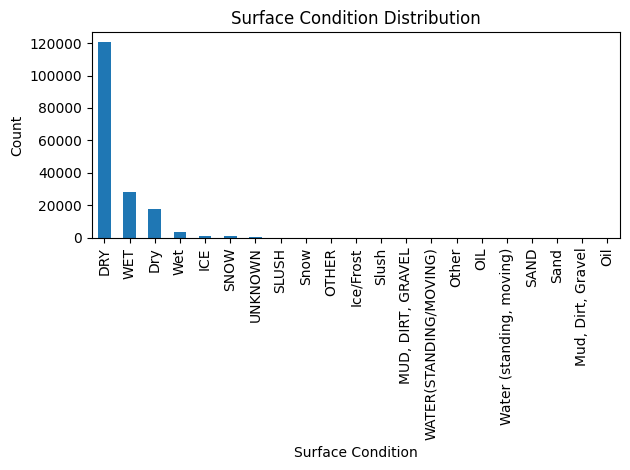

In [14]:
df['Surface Condition'].value_counts().plot(kind='bar', title='Surface Condition Distribution')
plt.xlabel('Surface Condition')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

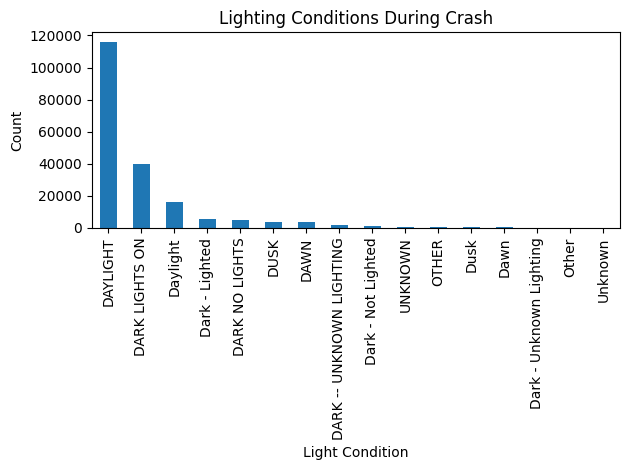

In [15]:
df['Light'].value_counts().plot(kind='bar', title='Lighting Conditions During Crash')
plt.xlabel('Light Condition')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

We checked if there's a pattern between average speed limits and injury severity. Fatal injuries happened at slightly higher speed limits but the differences aren’t too significant.

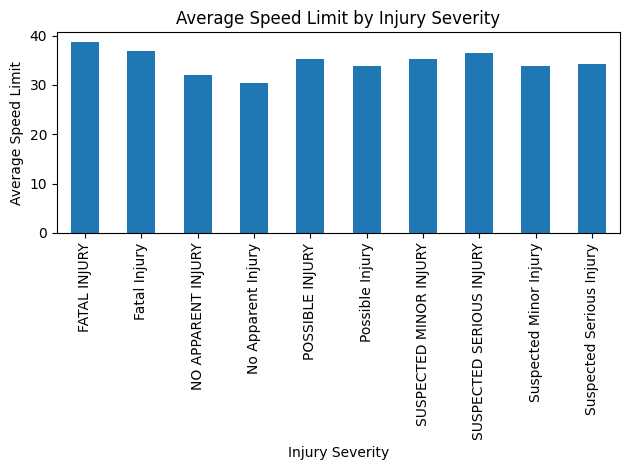

In [16]:
df.groupby('Injury Severity')['Speed Limit'].mean().plot(kind='bar')
plt.ylabel('Average Speed Limit')
plt.title('Average Speed Limit by Injury Severity')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

## Initial preprocessing and cleaning

- Treat missing and bad data
- Remove useless or irrelevant columns
- Remove any  output related columns

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195692 entries, 0 to 195691
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Report Number                  195692 non-null  object 
 1   Local Case Number              195692 non-null  object 
 2   Agency Name                    195692 non-null  object 
 3   ACRS Report Type               195692 non-null  object 
 4   Crash Date/Time                195692 non-null  object 
 5   Route Type                     176568 non-null  object 
 6   Road Name                      174569 non-null  object 
 7   Cross-Street Name              164921 non-null  object 
 8   Off-Road Description           18086 non-null   object 
 9   Municipality                   19126 non-null   object 
 10  Related Non-Motorist           6310 non-null    object 
 11  Collision Type                 195107 non-null  object 
 12  Weather                       

**Irrelevant Columns**:

(*We are focusing on features that could potentially have an impact severity level of a crash*)

- ID numbers (Report Number, Local Case Number, etc)
- ACRS Report Type, Off-Road Description, Drivers License State (Dataset focuses mainly on Maryland), Route Type (Not many unique routes since the focus is Maryland)
- Too many NAs: Municipality, Related Non-Motorist, Non-Motorist Substance Abuse, Circumstance
- Driverless vehicle values are No or Unknown, since there are only a few rows of Unknown, we can just remove those rows
- Location / Lat / Long are not really predictive
- We can just grab hour and weekday from Date/Time

In [18]:
# Convert Date to pandas
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])
df['Crash Hour'] = df['Crash Date/Time'].dt.hour
df['Crash Weekday'] = df['Crash Date/Time'].dt.weekday

# IDs/Names
df.drop(['Report Number', 'Local Case Number', 'Agency Name', 'Road Name', 'Cross-Street Name', 'Person ID', 'Vehicle ID'], axis=1, inplace=True)
# Descriptions
df.drop(['ACRS Report Type', 'Off-Road Description', 'Drivers License State', 'Route Type'], axis=1, inplace=True)
# Too Many NAs or unbalanced
df.drop(['Municipality', 'Related Non-Motorist', 'Non-Motorist Substance Abuse', 'Circumstance', 'Driverless Vehicle'], axis=1, inplace=True)
# Drop Lat, Long, and Loc, Date, or Useless
df.drop(['Latitude', 'Longitude', 'Location', 'Crash Date/Time', 'Vehicle Going Dir', 'Parked Vehicle'], axis=1, inplace=True)

df.info()

<ipython-input-18-01b11771ee8f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195692 entries, 0 to 195691
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Collision Type                 195107 non-null  object
 1   Weather                        182336 non-null  object
 2   Surface Condition              173324 non-null  object
 3   Light                          194247 non-null  object
 4   Traffic Control                168115 non-null  object
 5   Driver Substance Abuse         164372 non-null  object
 6   Driver At Fault                195692 non-null  object
 7   Injury Severity                194194 non-null  object
 8   Driver Distracted By           194074 non-null  object
 9   Vehicle Damage Extent          195376 non-null  object
 10  Vehicle First Impact Location  195536 non-null  object
 11  Vehicle Body Type              192759 non-null  object
 12  Vehicle Movement               194535 non-nu

Before we look more into the predictors, lets see how the data looks inside out target value.

In [19]:
df['Injury Severity'].value_counts()

,count
Injury Severity,
NO APPARENT INJURY,141196
No Apparent Injury,18301
POSSIBLE INJURY,17481
SUSPECTED MINOR INJURY,11871
Suspected Minor Injury,1998
Possible Injury,1566
SUSPECTED SERIOUS INJURY,1414
Suspected Serious Injury,188
FATAL INJURY,154


The categories seem to range between no injury, minor injury, serious injury and fatal injury. Since there are alot of "possible injuries", we can't just remove them, so our safest bet would be to just sepearte no injury and injuries into two distinct categories! We can also encode our column values using ordinal encoding.

In [20]:
df['Injury'] = df['Injury Severity'].str.upper()
df.loc[df['Injury'] != 'NO APPARENT INJURY', 'Injury'] = 'INJURY'
df['Injury'] = df['Injury'].replace({
    'NO APPARENT INJURY': 'NO INJURY'
})
severity_map = {
    'NO INJURY': 0,
    'INJURY': 1
}
df['Injury'] = df['Injury'].map(severity_map)
df.drop('Injury Severity', axis=1, inplace=True)

In [21]:
df['Injury'].value_counts()

,count
Injury,
0,159497
1,36195


Now lets work on cleaning up our predictor values:
- Collision type has several unique values, so just focusing on the most seen
- Weather has many unique values, but too many unknown, so just grabbing top 5
- The top 4 Surface Condition take up almost every row, so we can just set the rare occasions to OTHER.
- Light just needs a few values combined.
- Traffic control has a lot more unique values, grabbing top 3, rest as other
- Driver at fault is good as it is
- Top 2 substance abuse categories simplified
- Simplified Driver Distracted By and kept Other and Unknown as sepearate values since we have too many unknown values to just remove them, but other does not mean unknown since it could mean some type of distraction, so I kept them seperate.
- Grabbed the top 3 most seen damage types.
- The times had many similar values but different formatting (extra spacing, different caps), so by normalizing to data with uppercase and removing spaces, we combined many values and grabbed the top 6.
- Simplified a few car body types and grabbed top 5
- Grabbed the top 5 vehicle movements based on value count
- Simplified and grabbed the most seen car makes and models.
- There are a few car years that go over 2025 and lower than 1980, so it is probably best to drop those.

In [22]:
# Top 5 collision types
top_collision_types = df['Collision Type'].str.upper().value_counts().index[:6]
df['Collision Type'] = df['Collision Type'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_collision_types else 'OTHER'
)

# Top 4 weather conditions
top_weather = df['Weather'].str.upper().value_counts().index[:5]
df['Weather'] = df['Weather'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_weather else 'OTHER'
)
df['Weather'] = df['Weather'].replace({
    'RAINING': 'RAIN'
})

# Top 3 surface conditions
top_surface = df['Surface Condition'].str.upper().value_counts().index[:4]
df['Surface Condition'] = df['Surface Condition'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_surface else 'OTHER'
)

# Top 6 Light conditions
df['Light'] = df['Light'].replace({
    'DARK - LIGHTED': 'DARK LIGHTS ON',
    'DARK - NOT LIGHTED': 'DARK NO LIGHTS',
})
top_light = df['Light'].str.upper().value_counts().index[:6]
df['Light'] = df['Light'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_light else 'OTHER'
)

# Top 3 traffic controls
top_traffic = df['Traffic Control'].str.upper().value_counts().index[:6]
df['Traffic Control'] = df['Traffic Control'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_traffic else 'OTHER'
)
df['Traffic Control'] = df['Traffic Control'].replace({
    'TRAFFIC CONTROL SIGNAL': 'TRAFFIC SIGNAL',
    'FLASHING TRAFFIC SIGNAL': 'TRAFFIC SIGNAL'
})

# Top 2 substance abuse
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].str.upper().replace({'UNKNOWN': 'OTHER'})
top_substance = df['Driver Substance Abuse'].value_counts().index[:4]
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].apply(
    lambda x: x if x in top_substance else 'OTHER'
)
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].replace({
    'NOT SUSPECT OF ALCOHOL USE, NOT SUSPECT OF DRUG USE': 'NONE DETECTED'
})

# Top 3 distractions
df['Driver Distracted By'] = df['Driver Distracted By'].str.upper().replace({
    'OTHER DISTRACTION': 'OTHER',
    'OTHER ACTION (LOOKING AWAY FROM TASK, ETC.)': 'OTHER',
    'UNKNOWN': 'OTHER'
})
top_distractions = df['Driver Distracted By'].value_counts().index[:4]
df['Driver Distracted By'] = df['Driver Distracted By'].apply(
    lambda x: x if x in top_distractions else 'OTHER'
)

# Top 3 damage types
top_damage = df['Vehicle Damage Extent'].str.upper().value_counts().index[:4]
df['Vehicle Damage Extent'] = df['Vehicle Damage Extent'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_damage else 'OTHER'
)

# Top 5 impact locations
top_times = df['Vehicle First Impact Location'].str.upper().str.replace(" ", "").value_counts().index[:6]
df['Vehicle First Impact Location'] = df['Vehicle First Impact Location'].apply(
    lambda x: str(x).upper().replace(" ", "") if str(x).upper().replace(" ", "") in top_times else 'OTHER'
)

# Top 5 vehicle body types
top_body = df['Vehicle Body Type'].str.upper().value_counts().index[:7]
df['Vehicle Body Type'] = df['Vehicle Body Type'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_body else 'OTHER'
)
df['Vehicle Body Type'] = df['Vehicle Body Type'].replace({
    '(SPORT) UTILITY VEHICLE': 'SPORT UTILITY VEHICLE',
    'TRANSIT BUS': 'BUS',
    'SCHOOL BUS': 'BUS'
})

# Top 5 vehicle movements
top_movement = df['Vehicle Movement'].str.upper().value_counts().index[:5]
df['Vehicle Movement'] = df['Vehicle Movement'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_movement else 'OTHER'
)

# Top 4 car makes
top_make = df['Vehicle Make'].str.upper().value_counts().index[:6]
df['Vehicle Make'] = df['Vehicle Make'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_make else 'OTHER'
)
df['Vehicle Make'] = df['Vehicle Make'].replace({
    'TOYT': 'TOYOTA',
    'HOND': 'HONDA'
})

# Top 6 car models
top_model = df['Vehicle Model'].str.upper().value_counts().index[:6]
df['Vehicle Model'] = df['Vehicle Model'].apply(
    lambda x: str(x).upper() if str(x).upper() in top_model else 'OTHER'
)

# Drop bad car years
df = df[(df['Vehicle Year'] >= 1980) & (df['Vehicle Year'] <= 2025)]

# Label weekday
df['Crash Weekday'] = df['Crash Weekday'].replace({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

# Drop NA rows (Only a few na rows in injury)
df = df.dropna();

<ipython-input-22-d84b7c148b59>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Crash Weekday'] = df['Crash Weekday'].replace({


Let us take a look at the columns now!

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190728 entries, 0 to 195691
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Collision Type                 190728 non-null  object
 1   Weather                        190728 non-null  object
 2   Surface Condition              190728 non-null  object
 3   Light                          190728 non-null  object
 4   Traffic Control                190728 non-null  object
 5   Driver Substance Abuse         190728 non-null  object
 6   Driver At Fault                190728 non-null  object
 7   Driver Distracted By           190728 non-null  object
 8   Vehicle Damage Extent          190728 non-null  object
 9   Vehicle First Impact Location  190728 non-null  object
 10  Vehicle Body Type              190728 non-null  object
 11  Vehicle Movement               190728 non-null  object
 12  Speed Limit                    190728 non-null  i

We succesfully simplified our predictor variables and did not lose too much data! Now we can start encoding our categorical values.

In [24]:
df = pd.get_dummies(df, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190728 entries, 0 to 195691
Data columns (total 69 columns):
 #   Column                                       Non-Null Count   Dtype
---  ------                                       --------------   -----
 0   Speed Limit                                  190728 non-null  int64
 1   Vehicle Year                                 190728 non-null  int64
 2   Crash Hour                                   190728 non-null  int32
 3   Injury                                       190728 non-null  int64
 4   Collision Type_OTHER                         190728 non-null  bool 
 5   Collision Type_SAME DIR REAR END             190728 non-null  bool 
 6   Collision Type_SAME DIRECTION SIDESWIPE      190728 non-null  bool 
 7   Collision Type_SINGLE VEHICLE                190728 non-null  bool 
 8   Collision Type_STRAIGHT MOVEMENT ANGLE       190728 non-null  bool 
 9   Weather_CLOUDY                               190728 non-null  bool 
 10  Weather_OTHER

In [25]:
df.sample(5)

,Speed Limit,Vehicle Year,Crash Hour,Injury,Collision Type_OTHER,Collision Type_SAME DIR REAR END,Collision Type_SAME DIRECTION SIDESWIPE,Collision Type_SINGLE VEHICLE,Collision Type_STRAIGHT MOVEMENT ANGLE,Weather_CLOUDY,...,Vehicle Model_CIVIC,Vehicle Model_COROLLA,Vehicle Model_OTHER,Vehicle Model_TK,Crash Weekday_Monday,Crash Weekday_Saturday,Crash Weekday_Sunday,Crash Weekday_Thursday,Crash Weekday_Tuesday,Crash Weekday_Wednesday
15297,35,2005,22,0,False,True,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
45999,10,2013,16,0,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
73858,40,2023,6,0,False,True,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
191961,35,2010,19,0,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
94651,25,2016,8,0,True,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False


Great now we can start the preperation for machine learning!

# Machine learning

## Data preparation for machine learning

### Convert Pandas data to NumPy

In [26]:
target = 'Injury'
predictors = df.columns[~df.columns.isin(['Injury'])]

In [27]:
X = df[predictors].values
y = df[target].values

### Train/test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('The training set has {} rows, with {} predictor variables.'.format(X_train.shape[0], X_train.shape[1]))

The training set has 152582 rows, with 68 predictor variables.


### Scale the data

In [29]:
quant_features = [0,1,2]
xform = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), quant_features)
    ],
    remainder='passthrough'
)

X_train = xform.fit_transform(X_train)
X_test  = xform.transform(X_test)

print(X_train.shape)

(152582, 68)


Based on our rows and predictor values from our train/split and our scaled size, the size was not changed and by viewing the indexes, we can see the scaled values.

### Compute baseline accuracy

In [ ]:
majority_class = pd.Series(y_train).value_counts().index[0]
baseline_accuracy = (majority_class == y_train).mean()
print(f"Baseline accuracy: {baseline_accuracy:.3f}")

Baseline accuracy: 0.818


To outperform the baseline accuracy of 0.818, our model must achieve an accuracy rate greater than 0.818.

In [ ]:
def plot_learning_curve(clf, X_train, y_train):
    train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve, Logistic Regression')
    plt.legend();

## Logistic regression

In [ ]:
reg = LogisticRegression();
reg.fit(X_train, y_train);
print("Test accuracy:", reg.score(X_test, y_test));

Test accuracy: 0.819680196801968


now lets plot our learning curve to see how our train and test data performing

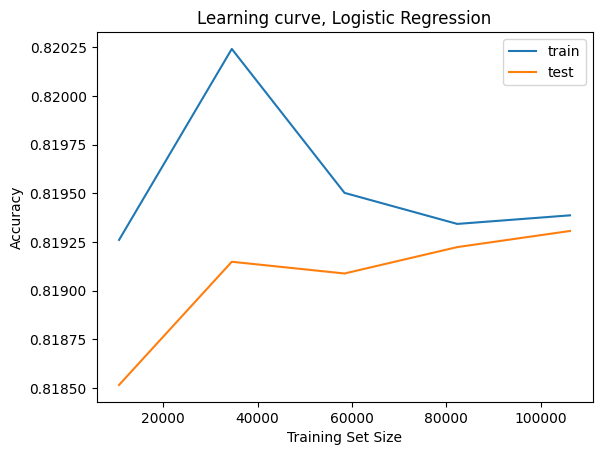

In [ ]:
plot_learning_curve(reg, X_train, y_train)

### Cross Validation

In [ ]:
cv_scores = cross_val_score(reg, X, y, cv=5, scoring='accuracy')
print("All the 5-fold CV accuracy:", cv_scores)
print("5-fold CV accuracy:", cv_scores.mean())

All the 5-fold CV accuracy: [0.81729046 0.81723774 0.81657881 0.81754922 0.81754922]
5-fold CV accuracy: 0.8172410917155905


We achieved a test accuracy slightly above our 0.818 baseline, so technically the model performs better. However, when we use 5 folds cross-validation with all 16 predictors, accuracy drops down and takes a lot of time to run suggesting some features may be irrelevant or makes noise in our prediction process.

The next steps is to try a different Machine Learning model as we know Logistic regression performs better with binary classification and in our case the injury Severity has more than two unique values, then apply systematic hyperparameter tuning and use feature selection to identify the strongest predictors.

Notes: Neutral selection

## Extra Credit (Unsupervised Learning)

## Conclusions